## Deep Inverse Regression with Yelp reviews

In this note we'll use [gensim](http://radimrehurek.com/gensim/) to turn the Word2Vec machinery into a document classifier, as in [Document Classification by Inversion of Distributed Language Representations](http://arxiv.org/pdf/1504.07295v3) from ACL 2015.

### Data and prep

First, download to the same directory as this note the data from the [Yelp recruiting contest](https://www.kaggle.com/c/yelp-recruiting) on [kaggle](https://www.kaggle.com/):
* https://www.kaggle.com/c/yelp-recruiting/download/yelp_training_set.zip
* https://www.kaggle.com/c/yelp-recruiting/download/yelp_test_set.zip

You'll need to sign-up for kaggle.



You can then unpack the data and grab the information we need.  

In [8]:
# ### uncomment below if you want...
# ## ... copious amounts of logging info
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
rootLogger = logging.getLogger()
rootLogger.setLevel(logging.INFO)
# ## ... or auto-reload of gensim during development
# %load_ext autoreload
# %autoreload 2

First, we define a super simple parser

In [1]:
import re
contractions = re.compile(r"'|-|\"")
# all non alphanumeric
symbols = re.compile(r'(\W+)', re.U)
# single character removal
singles = re.compile(r'(\s\S\s)', re.I|re.U)
# separators (any whitespace)
seps = re.compile(r'\s+')

# cleaner (order matters)
def clean(text): 
    text = text.lower()
    text = contractions.sub('', text)
    text = symbols.sub(r' \1 ', text)
    text = singles.sub(' ', text)
    text = seps.sub(' ', text)
    return text

# sentence splitter
alteos = re.compile(r'([!\?])')
def sentences(l):
    l = alteos.sub(r' \1 .', l).rstrip("(\.)*\n")
    return l.split(".")

And put everything together in a review generator that provides tokenized sentences and the number of stars for every review.

In [2]:
from zipfile import ZipFile
import json

def YelpReviews(label):
    with ZipFile("yelp_%s_set.zip"%label, 'r') as zf:
        with zf.open("yelp_%s_set/yelp_%s_set_review.json"%(label,label)) as f:
            for line in f:
                rev = json.loads(line)
                yield {'y':rev['stars'],\
                       'x':[clean(s).split() for s in sentences(rev['text'])]}

For example:

In [3]:
YelpReviews("test").next()

{'x': [[u'nice', u'place', u'big', u'patio'],
  [u'now', u'offering', u'live', u'sketch', u'comedy'],
  [u'wednesday',
   u'november',
   u'17th',
   u'see',
   u'local',
   u'troupe',
   u'th',
   u'sic',
   u'sense',
   u'in',
   u'their',
   u'2nd',
   u'annual',
   u'holiday',
   u'show'],
  [u'lighter', u'snappier', u'take', u'on', u'the', u'holiday', u'times'],
  [u'not', u'for', u'the', u'easily', u'offended'],
  [u'sketches',
   u'include',
   u'the',
   u'scariest',
   u'holloween',
   u'costume',
   u'the',
   u'first',
   u'thanksgiving',
   u'and',
   u'who',
   u'shot',
   u'santa',
   u'claus'],
  [u'as',
   u'well',
   u'as',
   u'the',
   u'infectious',
   u'song',
   u'mama',
   u'christmas']],
 'y': 5}

Now, since the files are small we'll just read everything into in-memory lists.  It takes a minute ...

In [4]:
revtrain = list(YelpReviews("training"))
print len(revtrain), "training reviews"

## and shuffle just in case they are ordered
import numpy as np
np.random.shuffle(revtrain)

229907 training reviews


Finally, write a function to generate sentences -- ordered lists of words -- from reviews that have certain star ratings

In [5]:
def StarSentences(reviews, stars=[1,2,3,4,5]):
    for r in reviews:
        if r['y'] in stars:
            for s in r['x']:
                yield s

### Word2Vec modeling

We fit out-of-the-box Word2Vec

In [10]:
from gensim.models import Word2Vec
import multiprocessing

## create a w2v learner 
basemodel = Word2Vec(
    workers=multiprocessing.cpu_count(), # use your cores
    iter=3, # iter = sweeps of SGD through the data; more is better
    hs=1, negative=0 # we only have scoring for the hierarchical softmax setup
    )
print basemodel

Word2Vec(vocab=0, size=100, alpha=0.025)


Build vocab from all sentences (you could also pre-train the base model from a neutral or un-labeled vocabulary)

In [11]:
basemodel.build_vocab(StarSentences(revtrain))

2017-02-05 22:07:26,010 : INFO : collecting all words and their counts
2017-02-05 22:07:26,011 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-02-05 22:07:26,044 : INFO : PROGRESS: at sentence #10000, processed 107230 words, keeping 9212 word types
2017-02-05 22:07:26,078 : INFO : PROGRESS: at sentence #20000, processed 212439 words, keeping 13398 word types
2017-02-05 22:07:26,112 : INFO : PROGRESS: at sentence #30000, processed 316929 words, keeping 16558 word types
2017-02-05 22:07:26,145 : INFO : PROGRESS: at sentence #40000, processed 424862 words, keeping 19173 word types
2017-02-05 22:07:26,179 : INFO : PROGRESS: at sentence #50000, processed 532325 words, keeping 21442 word types
2017-02-05 22:07:26,214 : INFO : PROGRESS: at sentence #60000, processed 639265 words, keeping 23410 word types
2017-02-05 22:07:26,250 : INFO : PROGRESS: at sentence #70000, processed 745729 words, keeping 25239 word types
2017-02-05 22:07:26,289 : INFO : PROGRESS: at s

Now, we will _deep_ copy each base model and do star-specific training. This is where the big computations happen...

In [ ]:
from copy import deepcopy
starmodels = [deepcopy(basemodel) for i in range(5)]
for i in range(5):
    slist = list(StarSentences(revtrain, [i+1]))
    print i+1, "stars (", len(slist), ")"
    starmodels[i].train(  slist, total_examples=len(slist) )

2017-02-05 22:09:25,878 : INFO : training model with 8 workers on 42447 vocabulary and 100 features, using sg=0 hs=1 sample=0.001 negative=0


1 stars ( 246207 )


2017-02-05 22:09:26,887 : INFO : PROGRESS: at 14.94% examples, 901145 words/s, in_qsize 16, out_qsize 0
2017-02-05 22:09:27,902 : INFO : PROGRESS: at 30.87% examples, 923905 words/s, in_qsize 15, out_qsize 0
2017-02-05 22:09:28,903 : INFO : PROGRESS: at 46.94% examples, 941009 words/s, in_qsize 15, out_qsize 0
2017-02-05 22:09:29,910 : INFO : PROGRESS: at 62.36% examples, 936723 words/s, in_qsize 14, out_qsize 2
2017-02-05 22:09:30,917 : INFO : PROGRESS: at 78.28% examples, 941828 words/s, in_qsize 15, out_qsize 0
2017-02-05 22:09:31,922 : INFO : PROGRESS: at 93.81% examples, 940544 words/s, in_qsize 15, out_qsize 2
2017-02-05 22:09:32,231 : INFO : worker thread finished; awaiting finish of 7 more threads
2017-02-05 22:09:32,232 : INFO : worker thread finished; awaiting finish of 6 more threads
2017-02-05 22:09:32,254 : INFO : worker thread finished; awaiting finish of 5 more threads
2017-02-05 22:09:32,262 : INFO : worker thread finished; awaiting finish of 4 more threads
2017-02-05 2

2 stars ( 295371 )


2017-02-05 22:09:33,381 : INFO : PROGRESS: at 12.15% examples, 882041 words/s, in_qsize 16, out_qsize 1
2017-02-05 22:09:34,394 : INFO : PROGRESS: at 23.59% examples, 852523 words/s, in_qsize 14, out_qsize 1
2017-02-05 22:09:35,415 : INFO : PROGRESS: at 36.44% examples, 877880 words/s, in_qsize 14, out_qsize 2
2017-02-05 22:09:36,423 : INFO : PROGRESS: at 49.19% examples, 887906 words/s, in_qsize 15, out_qsize 0
2017-02-05 22:09:37,421 : INFO : PROGRESS: at 61.99% examples, 897221 words/s, in_qsize 15, out_qsize 2
2017-02-05 22:09:38,435 : INFO : PROGRESS: at 75.20% examples, 906171 words/s, in_qsize 13, out_qsize 2
2017-02-05 22:09:39,441 : INFO : PROGRESS: at 88.07% examples, 909193 words/s, in_qsize 15, out_qsize 0
2017-02-05 22:09:40,315 : INFO : worker thread finished; awaiting finish of 7 more threads
2017-02-05 22:09:40,316 : INFO : worker thread finished; awaiting finish of 6 more threads
2017-02-05 22:09:40,318 : INFO : worker thread finished; awaiting finish of 5 more threads

3 stars ( 437718 )


2017-02-05 22:09:41,453 : INFO : PROGRESS: at 8.11% examples, 883334 words/s, in_qsize 15, out_qsize 2
2017-02-05 22:09:42,476 : INFO : PROGRESS: at 17.00% examples, 923463 words/s, in_qsize 14, out_qsize 2
2017-02-05 22:09:43,482 : INFO : PROGRESS: at 25.22% examples, 914370 words/s, in_qsize 13, out_qsize 2
2017-02-05 22:09:44,482 : INFO : PROGRESS: at 33.21% examples, 905272 words/s, in_qsize 15, out_qsize 3
2017-02-05 22:09:45,491 : INFO : PROGRESS: at 41.88% examples, 912087 words/s, in_qsize 14, out_qsize 1
2017-02-05 22:09:46,495 : INFO : PROGRESS: at 50.56% examples, 920057 words/s, in_qsize 16, out_qsize 0
2017-02-05 22:09:47,505 : INFO : PROGRESS: at 59.26% examples, 923374 words/s, in_qsize 15, out_qsize 0
2017-02-05 22:09:48,511 : INFO : PROGRESS: at 67.90% examples, 925586 words/s, in_qsize 15, out_qsize 0


### Inversion of the distributed representations

At this point, we have 5 different word2vec language representations.  Each 'model' has been trained conditional (i.e., limited to) text from a specific star rating.  We will apply Bayes rule to go from _p(text|stars)_ to _p(stars|text)_.

For any new sentence we can obtain its _likelihood_ (lhd; actually, the composite likelihood approximation; see the paper) using the [score](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec.score) function in the `word2vec` class.  We get the likelihood for each sentence in the first test review, then convert to a probability over star ratings. Every sentence in the review is evaluated separately and the final star rating of the review is an average vote of all the sentences. This is all in the following handy wrapper.

In [10]:
"""
docprob takes two lists
* docs: a list of documents, each of which is a list of sentences
* models: the candidate word2vec models (each potential class)

it returns the array of class probabilities.  Everything is done in-memory.
"""

import pandas as pd # for quick summing within doc

def docprob(docs, mods):
    # score() takes a list [s] of sentences here; could also be a sentence generator
    sentlist = [s for d in docs for s in d]
    # the log likelihood of each sentence in this review under each w2v representation
    llhd = np.array( [ m.score(sentlist, len(sentlist)) for m in mods ] )
    # now exponentiate to get likelihoods, 
    lhd = np.exp(llhd - llhd.max(axis=0)) # subtract row max to avoid numeric overload
    # normalize across models (stars) to get sentence-star probabilities
    prob = pd.DataFrame( (lhd/lhd.sum(axis=0)).transpose() )
    # and finally average the sentence probabilities to get the review probability
    prob["doc"] = [i for i,d in enumerate(docs) for s in d]
    prob = prob.groupby("doc").mean()
    return prob

#### Test set example

As an example, we apply the inversion on the full test set.  

In [11]:
# read in the test set
revtest = list(YelpReviews("test"))

In [12]:
# get the probs (note we give docprob a list of lists of words, plus the models)
probs = docprob( [r['x'] for r in revtest], starmodels )

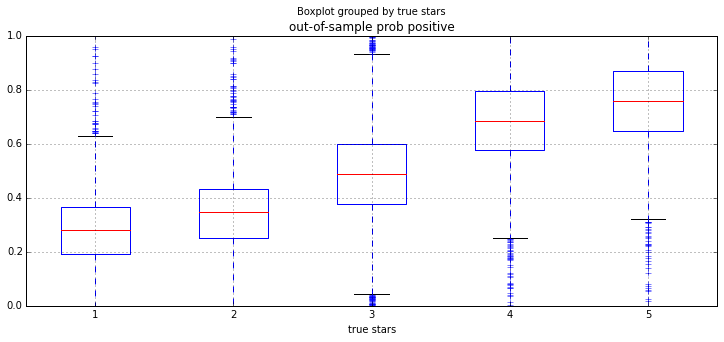

In [13]:
%matplotlib inline

probpos = pd.DataFrame({"out-of-sample prob positive":probs[[3,4]].sum(axis=1), 
                        "true stars":[r['y'] for r in revtest]})
probpos.boxplot("out-of-sample prob positive",by="true stars", figsize=(12,5))